# A Deep Neural Network Regressor - Rework for TBME

My first stab at this task will be to implement an **DNN Regressor** model.

In [1]:
%matplotlib inline

#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!ls data7

In [5]:
# df = pd.read_csv('data7/train.csv',header=None)
# print df.info()
# df.head()

KeyboardInterrupt: 

In [ ]:
# x_data = df.iloc[:,:-1].values.reshape((-1,30,224))
# y_data = df.iloc[:, -1].values

In [49]:
# Data load function
def load_data(filename,prints=False,spatial=False):
    data   = pd.read_csv(filename,header=None)
    if spatial:
        x_data = data.iloc[:,:-1].values.reshape((-1,30,224,1))
    else:
        x_data = data.iloc[:,:-1].values
    y_data = data.iloc[:,-1].values
    if prints:
        print 'X shape:', x_data.shape
        print 'Y shape:', y_data.shape
    return x_data,y_data

In [50]:
dataid   = 7
filename = 'data{}/train.csv'.format(dataid)
x_train,y_train=load_data(filename,spatial=True)
scaler   = MinMaxScaler(feature_range=(0,1)).fit(y_train.reshape(-1,1))
y_train  = scaler.transform(y_train.reshape(-1,1)).squeeze()
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.25,random_state=32)

## Regressor Model

In [18]:
# Keras Imports
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, AveragePooling2D
from keras.layers import Flatten, Reshape, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import PReLU
from keras import regularizers
from keras import backend as K
from keras.callbacks import TensorBoard

/home/junior/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [52]:
## Training Params
num_batch = 22
num_epoch = 15
patience  = 10

# Parameters
# ndim = x_train.shape[1]
npat,ndim,_ = x_train.shape[1:]
L1   = 127
L2   = 169
L3   = 16

In [53]:
# Build DNN
def build_model(cnn=False):
    if not cnn:
        x = Input(shape=(ndim,),name='Input')
        h = Dense(L1,activation='relu',name='L1')(x)
        h = BatchNormalization()(h)
        h = Dense(L2,activation='relu',kernel_regularizer=regularizers.l2(0.01),name='L2')(h)
        h = BatchNormalization()(h)
        h = Dense(L3,activation='relu',kernel_regularizer=regularizers.l2(0.01),name='L3')(h)
        h = BatchNormalization()(h)
        y = Dense(1,activation='linear',name='Output')(h)
        
    else:
        x = Input(shape=(npat,ndim,1),name='Input')
        h = Conv2D(16,kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
        h = BatchNormalization()(h)
        h = Conv2D(16,kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
        h = BatchNormalization()(h)
        h = Conv2D(8,kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
        h = BatchNormalization()(h)
        h = AveragePooling2D((2,2),strides=(2,2))(h)
        h = Flatten()(h)
        h = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.01),name='L4')(h)
        y = Dense(1,activation='linear',name='Output')(h)

    model = Model(x,y)
    return model

In [54]:
x_train.shape

(43312, 30, 224, 1)

In [57]:
# Compile Model
model = build_model(cnn=True)
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 30, 224, 1)        0         
_________________________________________________________________
L1 (Conv2D)                  (None, 15, 75, 16)        256       
_________________________________________________________________
batch_normalization_45 (Batc (None, 15, 75, 16)        64        
_________________________________________________________________
L2 (Conv2D)                  (None, 8, 25, 16)         2320      
_________________________________________________________________
batch_normalization_46 (Batc (None, 8, 25, 16)         64        
_________________________________________________________________
L3 (Conv2D)                  (None, 8, 9, 8)           1160      
_________________________________________________________________
batch_normalization_47 (Batc (None, 8, 9, 8)           32        
__________

In [58]:
# Train Model
log = model.fit(x_train, y_train,
              batch_size=num_batch,
              epochs=num_epoch,
              shuffle=True,
              validation_data=(x_valid,y_valid))

Train on 43312 samples, validate on 14438 samples
Epoch 1/15
43312/43312 [==============================] - 31s 706us/step - loss: 0.1123 - val_loss: 0.0421
Epoch 2/15
43312/43312 [==============================] - 30s 688us/step - loss: 0.0331 - val_loss: 0.0360
Epoch 3/15
43312/43312 [==============================] - 30s 689us/step - loss: 0.0259 - val_loss: 0.0235
Epoch 4/15
43312/43312 [==============================] - 30s 683us/step - loss: 0.0228 - val_loss: 0.0183
Epoch 5/15
43312/43312 [==============================] - 30s 686us/step - loss: 0.0207 - val_loss: 0.0229
Epoch 6/15
43312/43312 [==============================] - 30s 686us/step - loss: 0.0191 - val_loss: 0.0161
Epoch 7/15
43312/43312 [==============================] - 30s 687us/step - loss: 0.0178 - val_loss: 0.0195
Epoch 8/15
43312/43312 [==============================] - 30s 681us/step - loss: 0.0171 - val_loss: 0.0182
Epoch 9/15
43312/43312 [==============================] - 30s 687us/step - loss: 0.0163 - val_

In [59]:
model.save('model{}.h5'.format(dataid))

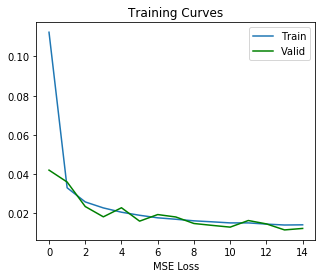

In [60]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.title('Training Curves')
# plt.ylim([0,0.05])
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid'])

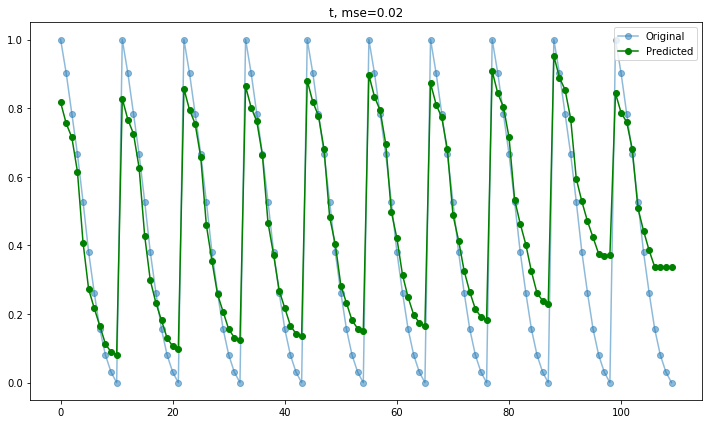

In [62]:
# Generate Predictions for Test Set
plt.figure(figsize=(10,6))

fname = 'data{}/test.csv'.format(dataid)
x_test,y_test=load_data(fname,spatial=True)
y_test = scaler.transform(y_test.reshape(-1,1)).squeeze()
y_predict = model.predict(x_test)
loss = model.evaluate(x_test,y_test,verbose=0)


# y_tst = scaler.inverse_transform(y_test.squeeze())
# y_prd = scaler.inverse_transform(y_predict.squeeze())
plt.subplot(111)
plt.plot(y_test,'o-',alpha=0.5)
plt.plot(y_predict,'go-')
header = '{0}, mse={1:.02f}'.format(fname[9:-4],loss)
plt.title(header)

# oname = 'data{}/ypred.csv'.format(dataid)
# tname = 'data{}/ytest.csv'.format(dataid)
# np.savetxt(oname,y_predict,delimiter=',')
# np.savetxt(tname,y_test,delimiter=',')

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

----